In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost

In [3]:
!pip install imbalanced-learn

In [4]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.3 MB/s eta 0:00:00


In [5]:
!pip install lightgbm

In [6]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import pytz
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree, export_text
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Ensure you have the necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import defaultdict
from collections import Counter
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_fscore_support
np.random.seed(0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Load Datasets

In [7]:
# load pickle file of the dataset with sentiment analysis added
df_filtered = pd.read_pickle('/content/drive/My Drive/twitter/twitter_sentiment.pkl')

In [8]:
# load pickle file of game_log_df
game_log_df = pd.read_pickle('/content/drive/My Drive/twitter/game_log_df.pkl')

In [9]:
print(game_log_df)

   team_action        action game_time  quarter  patriots_score  \
0     patriots          punt     11:44      1.0             0.0   
1     seahawks          punt     09:30      1.0             0.0   
2     patriots  interception     01:50      1.0             0.0   
3     seahawks          punt     14:08      2.0             0.0   
4     patriots     touchdown     09:47      2.0             7.0   
5     seahawks          punt     08:17      2.0             7.0   
6     patriots          punt     07:17      2.0             7.0   
7     seahawks     touchdown     02:16      2.0             7.0   
8     patriots     touchdown     00:31      2.0            14.0   
9     seahawks     touchdown     00:02      2.0            14.0   
10    seahawks    field_goal     11:09      3.0            14.0   
11    patriots  interception     08:15      3.0            14.0   
12    seahawks     touchdown     04:54      3.0            14.0   
13    patriots          punt     03:24      3.0            14.

In [10]:
def scale_times_to_hour(df, target_hour=19):
    # Read the last datetime object in the 'real_time' column
    last_datetime = df['real_time'].iloc[-1]

    # Extract the hour from the last datetime object
    last_hour = last_datetime.hour

    # Calculate the difference in hours to shift
    hour_diff = target_hour - last_hour

    # Define a function to shift the datetime by the hour difference
    def shift_time(dt, hours):
        return dt + pd.Timedelta(hours=hours)

    # Apply the shift to the 'real_time' column
    df['real_time'] = df['real_time'].apply(shift_time, hours=hour_diff)


    # Convert 'real_time' to datetime (assumed to be in UTC)
    df['real_time'] = pd.to_datetime(df['real_time'])

    return df

In [11]:
game_log_df = scale_times_to_hour(game_log_df)

In [12]:
print(game_log_df)

   team_action        action game_time  quarter  patriots_score  \
0     patriots          punt     11:44      1.0             0.0   
1     seahawks          punt     09:30      1.0             0.0   
2     patriots  interception     01:50      1.0             0.0   
3     seahawks          punt     14:08      2.0             0.0   
4     patriots     touchdown     09:47      2.0             7.0   
5     seahawks          punt     08:17      2.0             7.0   
6     patriots          punt     07:17      2.0             7.0   
7     seahawks     touchdown     02:16      2.0             7.0   
8     patriots     touchdown     00:31      2.0            14.0   
9     seahawks     touchdown     00:02      2.0            14.0   
10    seahawks    field_goal     11:09      3.0            14.0   
11    patriots  interception     08:15      3.0            14.0   
12    seahawks     touchdown     04:54      3.0            14.0   
13    patriots          punt     03:24      3.0            14.

# Combine the tweet dataset with the game activity dataset

In [13]:
# Sort the DataFrames
df_filtered = df_filtered.sort_values('time_posted', ascending=True)
game_log_df = game_log_df.sort_values('real_time', ascending=True)

# Convert 'real_time' in game_log_df to datetime with US/Pacific timezone
game_log_df['real_time'] = pd.to_datetime(game_log_df['real_time']).dt.tz_localize('US/Pacific')

# Merge the DataFrames on the closest previous time in game_scores_df for each tweet time
merged_df = pd.merge_asof(df_filtered.sort_values('time_posted'), game_log_df.sort_values('real_time'), left_on='time_posted', right_on='real_time', direction='backward')

# Identify the first and last events in the game log DataFrame
first_event = game_log_df.iloc[0]
last_event = game_log_df.iloc[-1]

# Identify the tweets posted before the start time of the game and after the end time of the game
tweets_before_game_start = df_filtered[df_filtered['time_posted'] < game_log_df['real_time'].min()]
tweets_after_game_end = df_filtered[df_filtered['time_posted'] > game_log_df['real_time'].max()]

# Paste the first event backward to the tweets that precede the start time of the game
if not tweets_before_game_start.empty:
    tweets_before_game_start = tweets_before_game_start.assign(**first_event)

# Paste the last event forward to the tweets that are posted after the end time of the game
if not tweets_after_game_end.empty:
    tweets_after_game_end = tweets_after_game_end.assign(**last_event)

# Concatenate the modified DataFrames
final_df = pd.concat([tweets_before_game_start, merged_df, tweets_after_game_end], ignore_index=True)

In [14]:
print(final_df.head())

                time_posted  retweets  followers    author_name     hashtag  \
0 2015-02-01 15:00:00-08:00         2     7664.0  Dennis Bounds     gohawks   
1 2015-02-01 15:00:00-08:00         1       37.0    mrs.Jozelia  gopatriots   
2 2015-02-01 15:00:00-08:00         1       53.0    Heidi Inman     gohawks   
3 2015-02-01 15:00:00-08:00         2       45.0    Gwenie Rose     gohawks   
4 2015-02-01 15:00:00-08:00         1      381.0     Sean Mason     gohawks   

                                                text  \
0  Touchdown in Seattle. Now for #seahawks TDs in...   
1  Hoje nÃ£o tem pra ninguÃ©m e patriots #GoPatri...   
2        #GoHawks that is all http://t.co/fV7t5QPXys   
3  Ready to party...#GoHawks #SB49 #Seahawks http...   
4                             30 minutes!!! #GoHawks   

                                        cleaned_text  \
0    touchdown seattle seahawks tds see game gohawks   
1  hoje tem pra ningum e patriots gopatriots gopa...   
2                   

In [15]:
print(final_df.shape)

(221356, 19)


In [16]:
print(final_df.tail())

                     time_posted  retweets  followers         author_name  \
221351 2015-02-01 19:59:50-08:00         1      149.0       Norman Norman   
221352 2015-02-01 19:59:55-08:00         1       60.0        Pete Naiukow   
221353 2015-02-01 19:59:57-08:00         4     1664.0  FoxboroughFire2252   
221354 2015-02-01 19:59:57-08:00         1      443.0          Lisa Mezik   
221355 2015-02-01 19:59:59-08:00         1     1423.0       cheryl daniel   

         hashtag                                               text  \
221351  patriots  Congrats to Tom Brady for breaking a post-seas...   
221352  patriots  #superbowlcommercials \n#PatriotsWIN #Patriots...   
221353  patriots  @Patriots Congratulations to our hometown New ...   
221354  patriots  The #Patriots Win 28-24!!!! #Superbowl49 http:...   
221355   gohawks  @eigenseide @DaynaOG @bcondotta Hope #Seahawks...   

                                             cleaned_text  \
221351  congrats tom brady breaking postseason re

In [17]:
# Function to calculate positive and negative sentiment scores
def calculate_sentiment_scores(sentiment_dict):
    return sentiment_dict['positive'], sentiment_dict['negative']

In [18]:
# Filter data for gohawks, gopatriots, and patriots hashtags
gohawks_df = final_df.loc[final_df['hashtag'] == 'gohawks'].copy()
patriots_df = final_df.loc[final_df['hashtag'].isin(['gopatriots', 'patriots'])].copy()

# Calculate positive and negative sentiment scores for gohawks
gohawks_df[['positive_sentiment', 'negative_sentiment']] = gohawks_df['sentiment_scores'].apply(
    lambda x: pd.Series(calculate_sentiment_scores(x)))

# Calculate positive and negative sentiment scores for patriots
patriots_df[['positive_sentiment', 'negative_sentiment']] = patriots_df['sentiment_scores'].apply(
    lambda x: pd.Series(calculate_sentiment_scores(x)))

# Group by time intervals (e.g., hourly) and calculate tweet and retweet frequency and sentiment scores
gohawks_grouped = gohawks_df.resample('H', on='time_posted').agg({
    'text': 'count',
    'retweets': 'sum',
    'positive_sentiment': 'mean',
    'negative_sentiment': 'mean'
})

patriots_grouped = patriots_df.resample('H', on='time_posted').agg({
    'text': 'count',
    'retweets': 'sum',
    'positive_sentiment': 'mean',
    'negative_sentiment': 'mean'
})

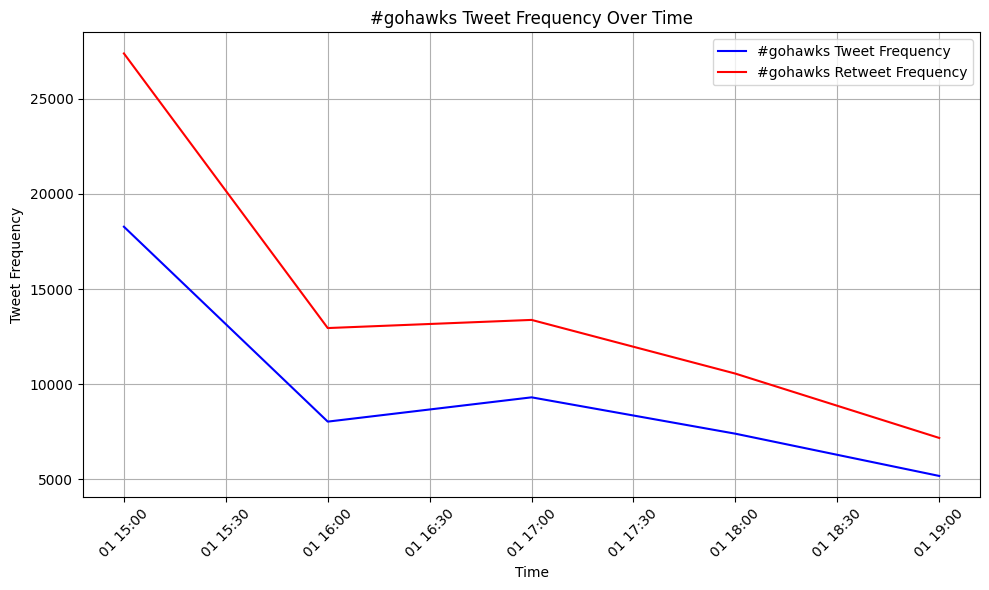

In [19]:
# Plot tweet frequency over time for gohawks
plt.figure(figsize=(10, 6))
plt.plot(gohawks_grouped.index, gohawks_grouped['text'], color='blue', label='#gohawks Tweet Frequency')
plt.plot(gohawks_grouped.index, gohawks_grouped['retweets'], color='red', label='#gohawks Retweet Frequency')
plt.xlabel('Time')
plt.ylabel('Tweet Frequency')
plt.title('#gohawks Tweet Frequency Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

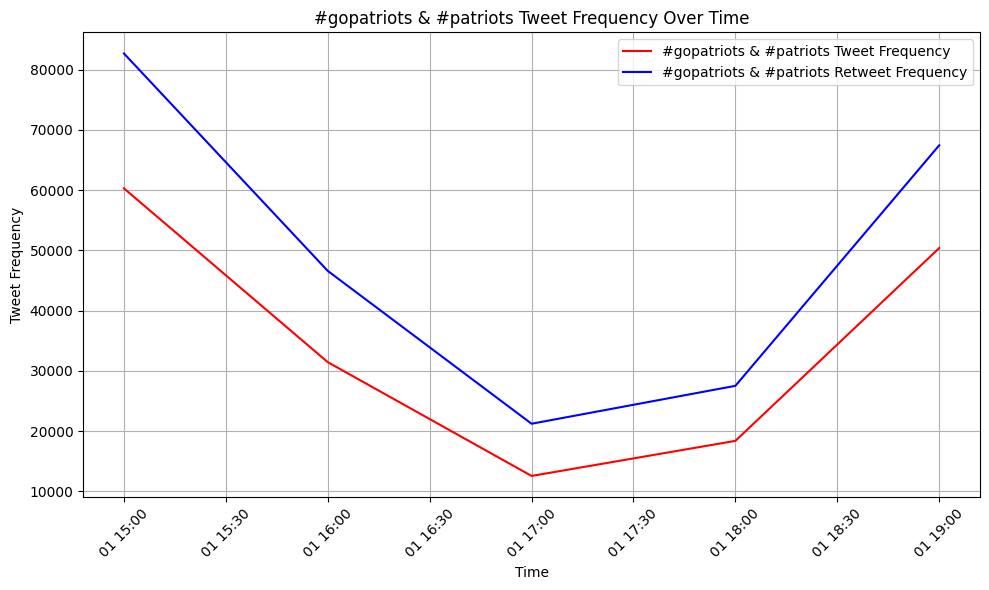

In [20]:
# Plot tweet frequency over time for gopatriots and patriots
plt.figure(figsize=(10, 6))
plt.plot(patriots_grouped.index, patriots_grouped['text'], color='red', label='#gopatriots & #patriots Tweet Frequency')
plt.plot(patriots_grouped.index, patriots_grouped['retweets'], color='blue', label='#gopatriots & #patriots Retweet Frequency')
plt.xlabel('Time')
plt.ylabel('Tweet Frequency')
plt.title('#gopatriots & #patriots Tweet Frequency Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I wanted to create a tweet frequency over time feature for both the hawks and patriots fans (as shown in these plots), but I was unable to get the merge to work properly.  Retweets will be retained as a feature, but I recognize it won't be predictive without aggregation.  

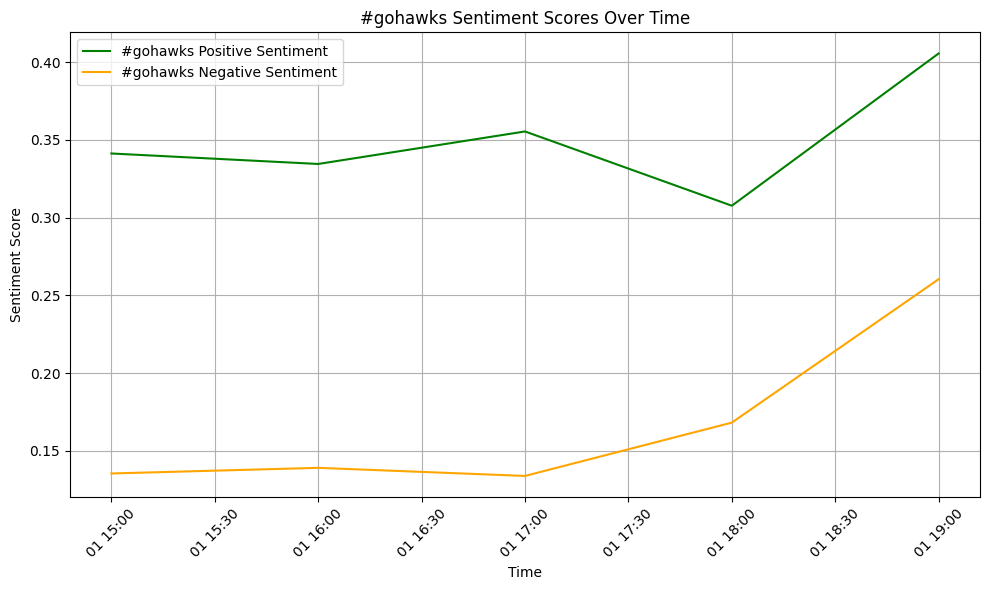

In [ ]:
# Plot positive and negative sentiment over time for gohawks
plt.figure(figsize=(10, 6))
plt.plot(gohawks_grouped.index, gohawks_grouped['positive_sentiment'], color='green', label='#gohawks Positive Sentiment')
plt.plot(gohawks_grouped.index, gohawks_grouped['negative_sentiment'], color='orange', label='#gohawks Negative Sentiment')
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.title('#gohawks Sentiment Scores Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

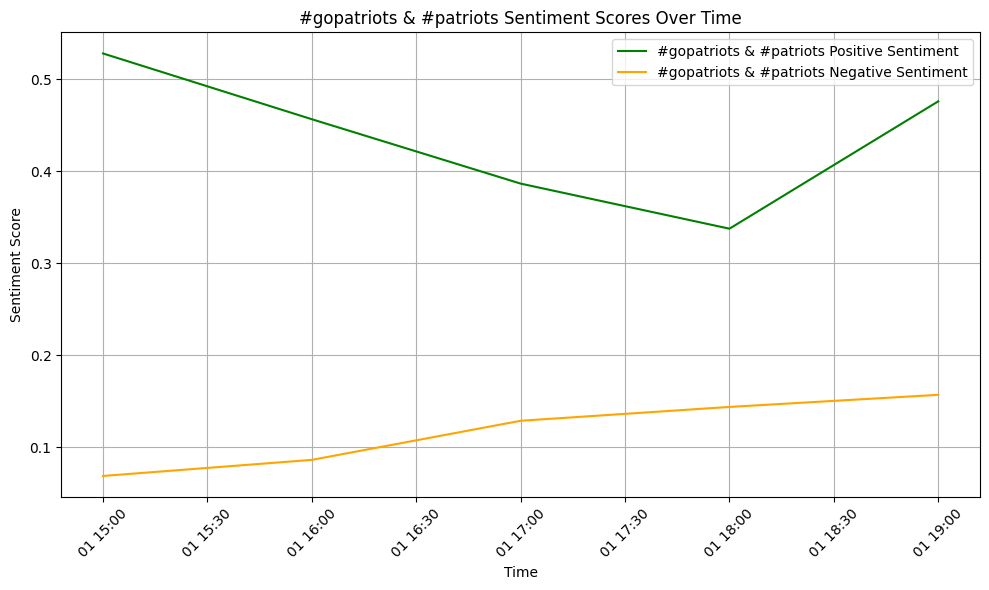

In [ ]:
# Plot positive and negative sentiment over time for gopatriots and patriots
plt.figure(figsize=(10, 6))
plt.plot(patriots_grouped.index, patriots_grouped['positive_sentiment'], color='green', label='#gopatriots & #patriots Positive Sentiment')
plt.plot(patriots_grouped.index, patriots_grouped['negative_sentiment'], color='orange', label='#gopatriots & #patriots Negative Sentiment')
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.title('#gopatriots & #patriots Sentiment Scores Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create dynamic labels for game score to determine the winning team across time

In [ ]:
# Assign dynamic labels for the winning team for labels
def determine_winning_team(row):
    if row['patriots_score'] > row['seahawks_score']:
        return 2
    elif row['patriots_score'] < row['seahawks_score']:
        return 1
    else:
        return 0

# patriots winning = 2
# seahawks winning = 1
# tie score = 0

In [ ]:
# Apply the function to each row to create a 'winning_team' column
final_df['winning_team'] = final_df.apply(determine_winning_team, axis=1)

#create labels as y
y = final_df['winning_team']

# Choose features for model training

In [ ]:
final_df['sentiment_positive'] = final_df['sentiment_positive'].astype(float)
final_df['sentiment_negative'] = final_df['sentiment_negative'].astype(float)
final_df['retweets'] = final_df['retweets'].astype(int)

In [ ]:
# Feature selection
features = ['sentiment_positive', 'sentiment_negative', 'retweets', 'hashtag', 'lemmatized_text', 'action', 'team_action']
X = final_df[features]

In [ ]:
# get the hashtag counts from final_df
hashtag_counts = final_df['hashtag'].value_counts()
print(hashtag_counts)

hashtag
patriots      156704
gohawks        48208
gopatriots     16444
Name: count, dtype: int64


# Balance the dataset

In [ ]:
# Function to balance the dataset by seahawks and patriots fans
def balance_dataset(df, label_column='hashtag', random_state=0):
    # Get counts of each label
    label_counts = df[label_column].value_counts()

    # Find the minimum count among the labels
    min_count = label_counts.min()

    # Sample equal number of samples for each label
    balanced_df = pd.concat([
        df[df[label_column] == label].sample(min_count, random_state=random_state)
        for label in label_counts.index
    ])

    # Shuffle the balanced DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=random_state)

    return balanced_df

In [ ]:
# Create a balanced dataset with equal numbers of seahawks and patriots fans
balanced_df = balance_dataset(final_df)

In [ ]:
# split the dataframe into X and y values
balanced_X = balanced_df[features]
balanced_y = balanced_df['winning_team']

In [ ]:
# Check size of balanced dataset
print(balanced_X.shape)
print(balanced_y.shape)

(49332, 7)
(49332,)


# Split data into train and test sets

In [ ]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(39465, 7)
(9867, 7)
(39465,)
(9867,)


# Create pipeline for preprocessing and model training

In [ ]:
# Function to preprocess the data and train the model
def train_and_evaluate_model(X_train, X_test, y_train, y_test, classifier):
    # Define transformers for different types of features
    transformers = [
        ('sentiment', 'passthrough', ['sentiment_positive', 'sentiment_negative']),
        ('retweets', 'passthrough', ['retweets']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['hashtag', 'action', 'team_action']),
        ('text', TfidfVectorizer(), 'lemmatized_text')
    ]

    # Create column transformer
    preprocessor = ColumnTransformer(transformers, remainder='drop')

    # Create a pipeline with preprocessor and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = pipeline.predict(X_test)

    # Define class names
    class_names = ['tie score', 'seahawks winning', 'patriots winning']
    # Print the classification report
    print(classification_report(y_test, y_pred, target_names=class_names))
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return pipeline

# Apply dimensionality reduction

                  precision    recall  f1-score   support

       tie score       0.95      0.96      0.95      6242
seahawks winning       0.88      0.89      0.88      2226
patriots winning       0.95      0.89      0.92      1399

        accuracy                           0.93      9867
       macro avg       0.93      0.91      0.92      9867
    weighted avg       0.93      0.93      0.93      9867



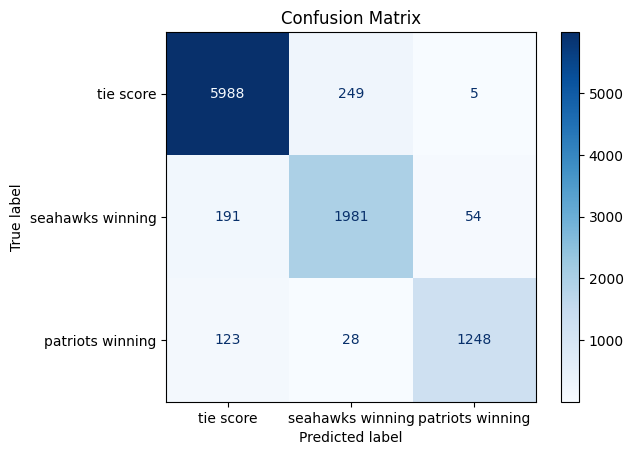

In [ ]:
# train a balanced Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
pipeline = train_and_evaluate_model(X_train, X_test, y_train, y_test, rf_classifier)

In [ ]:
# Access the Random Forest classifier from the pipeline
rf_classifier = pipeline.named_steps['classifier']

# Get feature importances
feature_importances = rf_classifier.feature_importances_

print(feature_importances)
print(feature_importances.size)

[1.89615549e-02 1.78620413e-02 4.75177638e-03 ... 9.61955948e-08
 8.68325642e-10 3.85561990e-06]
20838


Even with such a limited text field, the dimensinality of the feature set is very high with the sparse tweet text representations.  Lets try dimensionality reduction in the text field to reduce the number of features.

In [ ]:
def create_pipeline(n_components):
    transformers = [
        ('sentiment', 'passthrough', ['sentiment_positive', 'sentiment_negative']),
        ('retweets', 'passthrough', ['retweets']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['hashtag', 'action', 'team_action']),
        ('text', Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('lsi', TruncatedSVD(n_components=n_components))
        ]), 'lemmatized_text')
    ]

    preprocessor = ColumnTransformer(transformers, remainder='drop')

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=0))
    ])

    return pipeline

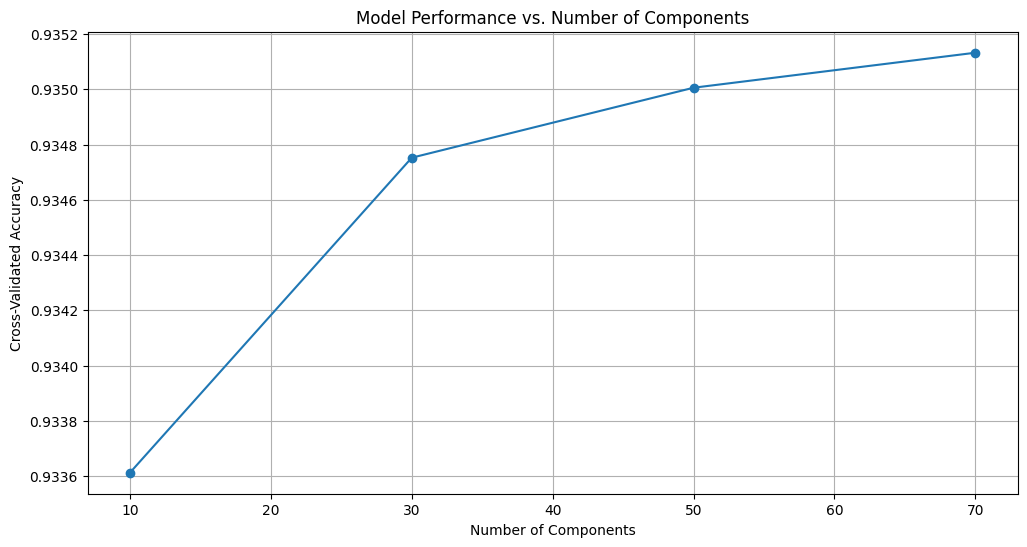

In [ ]:
n_components_list = [10, 30, 50, 70]
mean_scores = []

for n in n_components_list:
    pipeline = create_pipeline(n)
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy')
    mean_scores.append(scores.mean())

# Plot the cross-validation results
plt.figure(figsize=(12, 6))
plt.plot(n_components_list, mean_scores, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Model Performance vs. Number of Components')
plt.grid(True)
plt.show()

Although we get slightly higher accuracy at 70, we'll choose 50 due to computational complexity.

In [ ]:
# Function to preprocess the data and train the model
def train_and_evaluate_model_dimreduce(X_train, X_test, y_train, y_test, classifier):
    # Define transformers for different types of features
    transformers = [
        ('sentiment', 'passthrough', ['sentiment_positive', 'sentiment_negative']),
        ('retweets', 'passthrough', ['retweets']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['hashtag', 'action', 'team_action']),
        ('text', Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('lsi', TruncatedSVD(n_components=50))
        ]), 'lemmatized_text')
    ]

    # Create column transformer
    preprocessor = ColumnTransformer(transformers, remainder='drop')

    # Create a pipeline with preprocessor and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = pipeline.predict(X_test)

    # Define class names
    class_names = ['tie score', 'seahawks winning', 'patriots winning']
    # Print the classification report
    print(classification_report(y_test, y_pred, target_names=class_names))
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return pipeline

                  precision    recall  f1-score   support

       tie score       0.95      0.96      0.95      6242
seahawks winning       0.87      0.89      0.88      2226
patriots winning       0.95      0.90      0.92      1399

        accuracy                           0.93      9867
       macro avg       0.93      0.92      0.92      9867
    weighted avg       0.93      0.93      0.93      9867



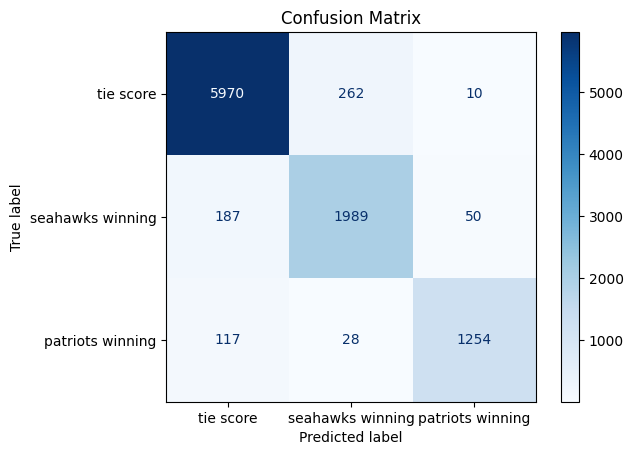

In [ ]:
# Train a random forest model with dimensionality reduction in the tweet text
rf_classifier_dimreduce = RandomForestClassifier(n_estimators=100, random_state=0)
pipeline = train_and_evaluate_model_dimreduce(X_train, X_test, y_train, y_test, rf_classifier_dimreduce)

In [ ]:
# Access the Random Forest classifier from the pipeline
rf_classifier_dimreduce = pipeline.named_steps['classifier']

# Get feature importances
feature_importances = rf_classifier_dimreduce.feature_importances_

print(feature_importances)
print(feature_importances.size)

[0.0094031  0.00865577 0.00300457 0.00442009 0.00121152 0.00288835
 0.00364087 0.11798264 0.14685939 0.10687625 0.02452144 0.10475662
 0.15228085 0.0207269  0.01016471 0.01524546 0.01435453 0.00736263
 0.01224002 0.00836731 0.00617952 0.00469267 0.00531722 0.00515967
 0.00701818 0.00537021 0.00552975 0.00595327 0.00816689 0.00496843
 0.00785501 0.00401798 0.00502189 0.00443502 0.0047265  0.00504998
 0.00431531 0.00513687 0.00507573 0.0055367  0.00785109 0.00431931
 0.00434225 0.00563956 0.00448265 0.00425799 0.00377692 0.00476299
 0.00456877 0.00446288 0.00643309 0.00543709 0.00416774 0.00540705
 0.00423194 0.0045011  0.00411945 0.0046451  0.0040635  0.00497364
 0.00469817 0.00484389 0.0043583  0.00516572]
64


I didn't lose much accuracy, and my 64 total features are much less sparse, so I'll implement dimensionality reduction going forward.  Plus, its also good practice to perform full LSI to improve overall model performance by enhancing generalization, reducing noise, and hopefully providing some interpretability downstream.

# Try other models

                  precision    recall  f1-score   support

       tie score       0.95      0.96      0.95      6242
seahawks winning       0.87      0.90      0.88      2226
patriots winning       0.96      0.89      0.92      1399

        accuracy                           0.93      9867
       macro avg       0.93      0.91      0.92      9867
    weighted avg       0.93      0.93      0.93      9867



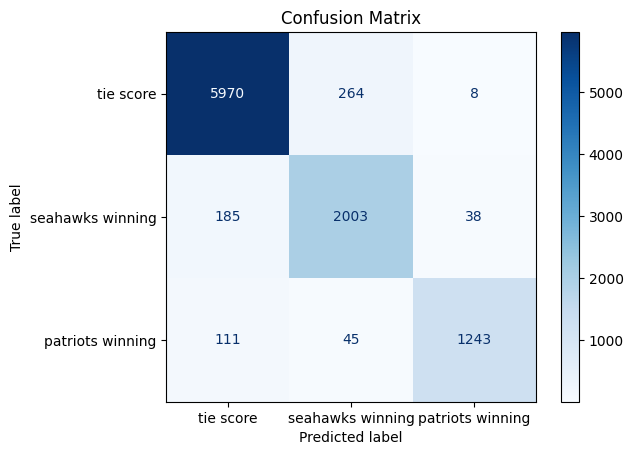

In [ ]:
# Train an XGBoost model
xgb_classifier = XGBClassifier(n_estimators=100, random_state=0, use_label_encoder=False, eval_metric='mlogloss')
pipeline = train_and_evaluate_model_dimreduce(X_train, X_test, y_train, y_test, xgb_classifier)

Learning rate set to 0.5
0:	learn: 0.5093198	total: 71.4ms	remaining: 7.07s
1:	learn: 0.3669745	total: 90.9ms	remaining: 4.45s
2:	learn: 0.2954490	total: 112ms	remaining: 3.62s
3:	learn: 0.2587371	total: 131ms	remaining: 3.15s
4:	learn: 0.2432919	total: 151ms	remaining: 2.88s
5:	learn: 0.2298154	total: 170ms	remaining: 2.66s
6:	learn: 0.2246412	total: 188ms	remaining: 2.49s
7:	learn: 0.2206170	total: 207ms	remaining: 2.38s
8:	learn: 0.2151701	total: 229ms	remaining: 2.31s
9:	learn: 0.2134574	total: 246ms	remaining: 2.21s
10:	learn: 0.2114160	total: 265ms	remaining: 2.14s
11:	learn: 0.2103326	total: 283ms	remaining: 2.07s
12:	learn: 0.2096158	total: 299ms	remaining: 2s
13:	learn: 0.2078519	total: 319ms	remaining: 1.96s
14:	learn: 0.2071265	total: 336ms	remaining: 1.9s
15:	learn: 0.2042534	total: 356ms	remaining: 1.87s
16:	learn: 0.2033226	total: 374ms	remaining: 1.82s
17:	learn: 0.2022471	total: 394ms	remaining: 1.8s
18:	learn: 0.2016666	total: 414ms	remaining: 1.76s
19:	learn: 0.200514

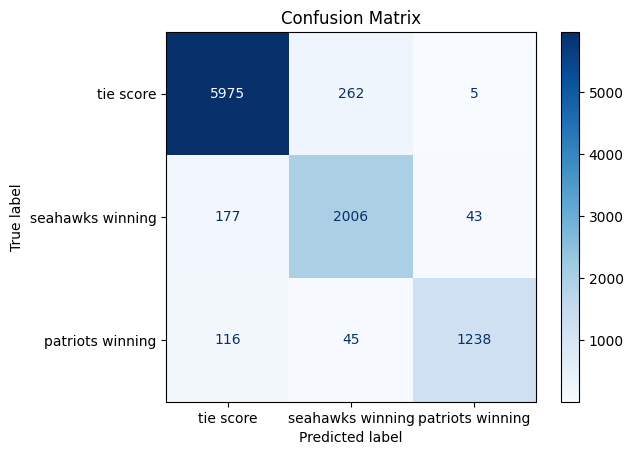

In [ ]:
# train a CatBoost model
catboost_classifier = CatBoostClassifier(n_estimators=100, random_state=0)
pipeline = train_and_evaluate_model_dimreduce(X_train, X_test, y_train, y_test, catboost_classifier)

                  precision    recall  f1-score   support

       tie score       0.92      0.95      0.94      6242
seahawks winning       0.87      0.89      0.88      2226
patriots winning       0.98      0.80      0.88      1399

        accuracy                           0.92      9867
       macro avg       0.92      0.88      0.90      9867
    weighted avg       0.92      0.92      0.91      9867



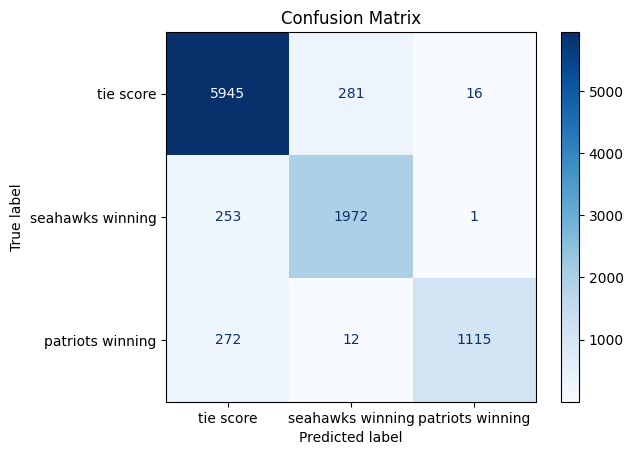

In [ ]:
# Train a Logistic Regression Model
lr_classifier = LogisticRegression(max_iter=200, solver='liblinear', random_state=0)
pipeline = train_and_evaluate_model_dimreduce(X_train, X_test, y_train, y_test, lr_classifier)

                  precision    recall  f1-score   support

       tie score       0.92      0.95      0.94      6242
seahawks winning       0.87      0.89      0.88      2226
patriots winning       1.00      0.80      0.89      1399

        accuracy                           0.92      9867
       macro avg       0.93      0.88      0.90      9867
    weighted avg       0.92      0.92      0.92      9867



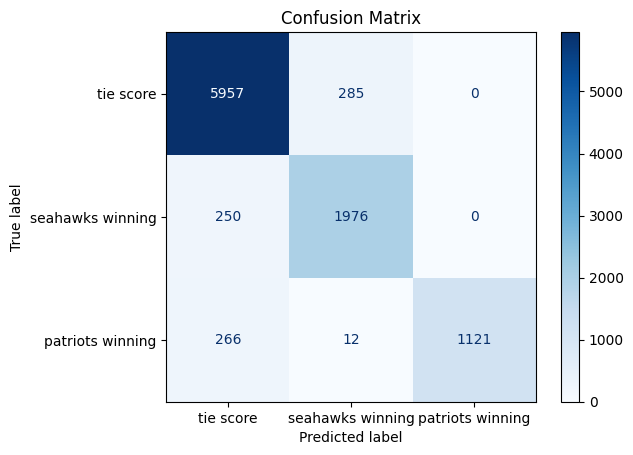

In [ ]:
# Train SVM model
svm_classifier = SVC(kernel='linear', random_state=0)
pipeline = train_and_evaluate_model_dimreduce(X_train, X_test, y_train, y_test, svm_classifier)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13321
[LightGBM] [Info] Number of data points in the train set: 39465, number of used features: 64
[LightGBM] [Info] Start training from score -0.476578
[LightGBM] [Info] Start training from score -1.469560
[LightGBM] [Info] Start training from score -1.903347
                  precision    recall  f1-score   support

       tie score       0.95      0.96      0.96      6242
seahawks winning       0.87      0.90      0.89      2226
patriots winning       0.96      0.89      0.92      1399

        accuracy                           0.94      9867
       macro avg       0.93      0.92      0.92      9867
    weighted avg       0.94      0.94      0.94      9867



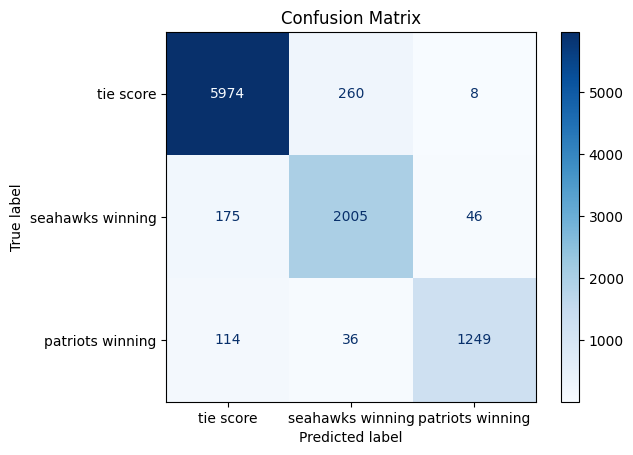

In [ ]:
# Train lightgbm model
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, random_state=0)
pipeline = train_and_evaluate_model_dimreduce(X_train, X_test, y_train, y_test, lgb_classifier)

# Final 5 Fold Cross Validated Grid Search for LightGBM model

In [ ]:
# Define the function to train and evaluate the model
def grid_search_evaluation(X_train, X_test, y_train, y_test, classifier):
    # Define transformers for different types of features
    transformers = [
        ('sentiment', 'passthrough', ['sentiment_positive', 'sentiment_negative']),
        ('retweets', 'passthrough', ['retweets']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['hashtag', 'action', 'team_action']),
         ('text', Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('lsi', TruncatedSVD(n_components=50))
        ]), 'lemmatized_text')
    ]

    # Create column transformer
    preprocessor = ColumnTransformer(transformers, remainder='drop')

    # Create a pipeline with preprocessor and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier(random_state=0))
    ])

    # Define the parameter grid for LGBMClassifier
    param_grid = {
        'classifier__n_estimators': [50, 100],
        'classifier__num_leaves': [31, 51],
        'classifier__max_depth': [-1, 3],
    }

    # Set up GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

    # Train the model using grid search
    grid_search.fit(X_train, y_train)

    # Get the best parameters, score, and model
    # Print the best parameters and best score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validated score: {grid_search.best_score_}")
    best_model = grid_search.best_estimator_

    # Predict and evaluate using the best model
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['tie score', 'seahawks winning', 'patriots winning']))
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['tie score', 'seahawks winning', 'patriots winning']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return best_model

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13321
[LightGBM] [Info] Number of data points in the train set: 39465, number of used features: 64
[LightGBM] [Info] Start training from score -0.476578
[LightGBM] [Info] Start training from score -1.469560
[LightGBM] [Info] Start training from score -1.903347
Best parameters: {'classifier__max_depth': -1, 'classifier__n_estimators': 50, 'classifier__num_leaves': 51}
Best cross-validated score: 0.9370834917015077
                  precision    recall  f1-score   support

       tie score       0.95      0.96      0.95      6242
seahawks winning       0.87      0.90      0.88      2226
patriots winning       0.96      0.89      0.92      1399

        accuracy                           0.93      9867
       macro avg       0.93      0.92   

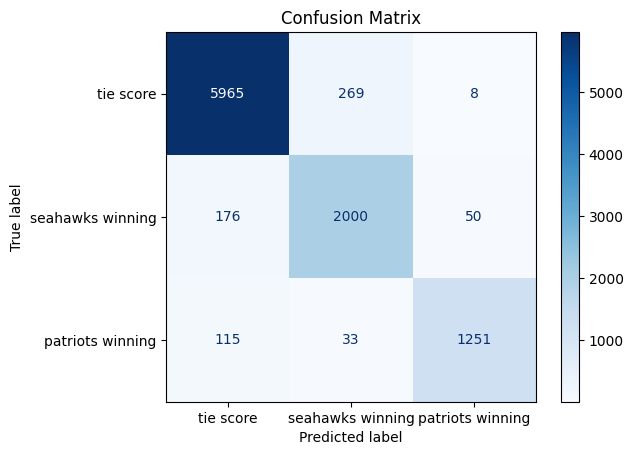

In [ ]:
#grid_search_evaluation(X_train, X_test, y_train, y_test, RandomForestClassifier)
best_model = grid_search_evaluation(X_train, X_test, y_train, y_test, lgb.LGBMClassifier)

In [ ]:
# Function to extract and analyze feature importances from LightGBM
def analyze_features(pipeline):
    classifier = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']

    # Extract feature importances from LightGBM model
    importances = classifier.feature_importances_

    # Get feature names for non-text features
    non_text_features = list(preprocessor.transformers_[0][2]) + \
                        list(preprocessor.transformers_[1][2]) + \
                        list(preprocessor.transformers_[2][1].get_feature_names_out())

    # Get the number of components for text features after SVD
    svd = preprocessor.transformers_[3][1].named_steps['lsi']
    n_components = svd.n_components

    # Create placeholder names for the reduced text features
    text_features = [f'text_component_{i}' for i in range(n_components)]

    # Combine all feature names
    feature_names = non_text_features + text_features

    # Ensure the length matches
    if len(feature_names) != len(importances):
        raise ValueError("Number of feature names does not match number of importances.")

    # Create a DataFrame for better visualization
    feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(14, 10))
    ax = plt.gca()
    bars = plt.barh(feature_importances_df['feature'], feature_importances_df['importance'])

    # Add padding between the bars
    for bar in bars:
        bar.set_height(bar.get_height() * 0.5)

    # Set title and labels
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Features')

    # Improve layout for better visibility
    plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
    plt.gca().invert_yaxis()

    plt.show()

    return feature_importances_df

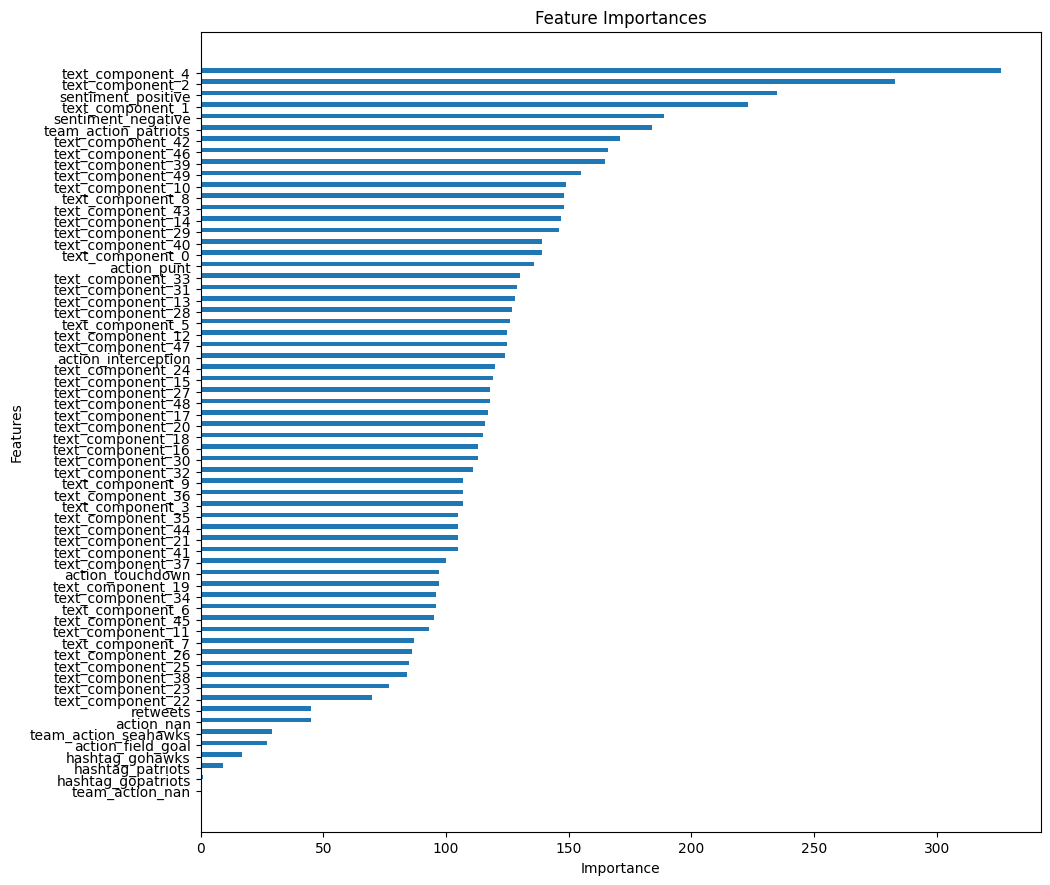

In [ ]:
# Analyze feature importances
feature_importances_df = analyze_features(best_model)

In [ ]:
# Function to align text components with actual words
def analyze_svd_components(pipeline, n_top_terms=10):
    preprocessor = pipeline.named_steps['preprocessor']

    # Get the TF-IDF and SVD objects from the pipeline
    tfidf = preprocessor.transformers_[3][1].named_steps['tfidf']
    svd = preprocessor.transformers_[3][1].named_steps['lsi']

    # Get the TF-IDF feature names (terms)
    tfidf_feature_names = tfidf.get_feature_names_out()

    # Get the SVD components
    svd_components = svd.components_

    # For each SVD component, get the top n terms
    for i, component in enumerate(svd_components):
        sorted_indices = component.argsort()[::-1]
        top_indices = sorted_indices[:n_top_terms]
        top_terms = [tfidf_feature_names[index] for index in top_indices]
        top_weights = component[top_indices]

        print(f"Text component {i}:")
        for term, weight in zip(top_terms, top_weights):
            print(f"  {term}: {weight}")
        print("\n")

In [ ]:
# Show top terms (words) in feature importance
analyze_svd_components(pipeline, n_top_terms=10)

Text component 0:
  ve: 0.5220998736118251
  patriotswin: 0.4935183074830683
  win: 0.4934361303037024
  get: 0.4874452697379226
  gopatriots: 0.025322223056887333
  gohawks: 0.019963079026374488
  superbowl: 0.01974786666589358
  patriot: 0.019624621560926835
  superbowlxlix: 0.016772951872442377
  go: 0.011055195564419138


Text component 1:
  gopatriots: 0.9343071220707548
  gohawks: 0.21788676736324813
  superbowl: 0.13705989042245742
  superbowlxlix: 0.1288892153260202
  touchdown: 0.11565525108661853
  patriot: 0.08189353480696794
  go: 0.06268244894737637
  gopats: 0.049298790117621984
  seahawks: 0.04078638220609031
  let: 0.040544411994697764


Text component 2:
  gohawks: 0.9481047266059519
  go: 0.07077487503199784
  superbowlxlix: 0.0665840047907548
  seahawks: 0.06649007025304439
  let: 0.0546804979671131
  touchdown: 0.04617582707347313
  superbowl: 0.03768725917974085
  patriot: 0.03289655069572725
  game: 0.03276601993756433
  beastmode: 0.02922159424945246


Text compo